# Sentence Transformers

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_jobs = pd.read_csv('jobs.csv')
df_resume = pd.read_csv('resume_sections.csv')
df_resume.drop(columns=['INTERESTS', 'AWARDS'], inplace=True)
df_resume.fillna('', inplace=True)

## Preprocessing

In [3]:
import re

def clean_description(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^a-zA-Z\+]', ' ', text)
    # Remove extra blank spaces
    text = re.sub(r'\s+', ' ', text).strip()
    # Convert to lowercase
    text = text.lower()
    return text

clean_description("I have skills in developing applications using Python3, React.js, and JavaScript.      I can use Java, express.JS and NodeJS!")

'i have skills in developing applications using python react js and javascript i can use java express js and nodejs'

In [4]:
# Combine text from all columns to get overall resume text
df_resume['clean_resume_text'] = df_resume[['PROFILE', 'EXPERIENCE', 'PROJECTS', 'CERTIFICATIONS']].apply(lambda row: ' '.join(row), axis=1).apply(clean_description)
df_resume.head()[['Filename', 'clean_resume_text']]

,Filename,clean_resume_text
0,Albana_be,web developer icf current oklahoma city ok par...
1,Anil_Sharma_X,as an enthusiastic graduate with a degree in e...
2,Ayla_Stone,web developer fanatics current jacksonville fl...
3,Hari_Tamang_I,software intern xyz tech solutions pokhara kas...
4,Ilias,junior software developer revature llc current...


In [5]:
df_resume.drop(columns=['PROFILE', 'CERTIFICATIONS'], inplace=True)

# Choose target job

In [6]:
target_job = df_jobs.loc[5]

Preprocess job description  
This adds the title, and skills to the description.  
Then cleans it.

In [7]:
def preprocess_job(target_job):
    title, description, skills = (
        target_job['title'],
        target_job['description'],
        target_job['skills'],
    )    # Clean description
    if skills:
        description = skills.replace(',', '') + ' ' + description
    if title:
        description = f'{title} {description}'
    description = clean_description(description)
    # print('Cleaned job description:', description)
    return description

In [8]:
import textwrap

wrapped_content = textwrap.fill(target_job['description'], 100)
print(wrapped_content)

 • Develop and maintain front-end and back-end components of web applications. • Design and
implement user-friendly interfaces using HTML, CSS, and JavaScript frameworks such as React or
Angular. • Write clean, efficient, and maintainable code in languages such as JavaScript, Python. •
Develop RESTful APIs and integrate third-party services as needed.  • Proficiency in front-end
technologies such as HTML, CSS, JavaScript, and front-end frameworks like React, Next.js •
Experience with back-end technologies such as Node.js, Python. • Strong understanding of RESTful
APIs and web services. • Familiarity with database technologies such as SQL, MongoDB, or PostgreSQL.
• Ability to write Unit and Integration Tests • Experience working with CI/CD pipelines • Highly
experienced with Agile methodologies like Scrum/Kanban • Strong communication and interpersonal
skills.


## Tfidf
For comparing job-description and resume-description

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [10]:

def get_description_score(target_job):
    # Initialize the TfidfVectorizer
    # min_df=3 means ignore terms that appear in less than 3 document
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', min_df=3)

    # fit_transform the vectorizers and create tfidf matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform([preprocess_job(target_job)] + df_resume['clean_resume_text'].values.tolist())
    
    # Calculate cosine similarity between the job description and resumes
    cosine_similarities = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:]).flatten()

    df_resume['description_score'] = cosine_similarities

In [11]:
get_description_score(target_job)

# BERT

In [12]:
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity

def get_sentence_transformer_model_score(target_job, model_name, model):
    print(f'\nModel={model_name} Embedding-Dimensions={model.get_sentence_embedding_dimension()}')

    job_embeddings = model.encode(preprocess_job(target_job))   
    # resume_embeddings = model.encode(df_resume['clean_resume_text'])

    resume_embeddings = np.zeros((len(df_resume), model.
    get_sentence_embedding_dimension()))
    for i in tqdm(range(len(df_resume)), desc='Encoding resume texts', unit='resumes'):
        resume_embeddings[i] = model.encode(df_resume.iloc[i]['clean_resume_text'])
    
    # Calculate cosine similarity between the job description and resumes
    cosine_similarities = cosine_similarity(resume_embeddings, [job_embeddings])

    # Set negative scores to 0
    cosine_similarities[cosine_similarities < 0] = 0

    df_resume[model_name] = cosine_similarities

## bert-base-nli-mean-tokens

In [13]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained sentence transformer model
MODEL_NAME = 'bert-base-nli-mean-tokens'
model = SentenceTransformer(MODEL_NAME)

In [14]:
get_sentence_transformer_model_score(target_job, MODEL_NAME, model)


Model=bert-base-nli-mean-tokens Embedding-Dimensions=768


Encoding resume texts: 100%|██████████| 15/15 [00:06<00:00,  2.31resumes/s]


## all-MiniLM-L12-v2 model

In [15]:
# Load a pre-trained sentence transformer model
MODEL_NAME = 'all-MiniLM-L12-v2'
model = SentenceTransformer(MODEL_NAME)

In [16]:
get_sentence_transformer_model_score(target_job, MODEL_NAME, model)


Model=all-MiniLM-L12-v2 Embedding-Dimensions=384


Encoding resume texts: 100%|██████████| 15/15 [00:02<00:00,  6.31resumes/s]


## all-MiniLM-L6-v2

In [17]:
# Load a pre-trained sentence transformer model
MODEL_NAME = 'all-MiniLM-L6-v2'
model = SentenceTransformer(MODEL_NAME)

In [18]:
get_sentence_transformer_model_score(target_job, MODEL_NAME, model)


Model=all-MiniLM-L6-v2 Embedding-Dimensions=384


Encoding resume texts: 100%|██████████| 15/15 [00:02<00:00,  7.49resumes/s]


In [19]:
df_resume[['Filename', 'clean_resume_text', 'description_score', 'bert-base-nli-mean-tokens', 'all-MiniLM-L12-v2', 'all-MiniLM-L6-v2']].sort_values(by='all-MiniLM-L12-v2', ascending=False)

,Filename,clean_resume_text,description_score,bert-base-nli-mean-tokens,all-MiniLM-L12-v2,all-MiniLM-L6-v2
6,Jeong_Kim,donationxchange web developer intern july curr...,0.421095,0.716248,0.589314,0.460648
2,Ayla_Stone,web developer fanatics current jacksonville fl...,0.128132,0.742487,0.568949,0.599610
13,SP,highly motivated computer engineering student ...,0.124668,0.707900,0.566015,0.592004
9,Ramesh_Chaudhary_I,as an enthusiastic graduate with a degree in e...,0.353725,0.756043,0.559163,0.650750
10,Ramika_Shrestha_I,abc software solutions april october software ...,0.357353,0.699788,0.528207,0.656318
0,Albana_be,web developer icf current oklahoma city ok par...,0.237370,0.728357,0.519924,0.526595
7,John_Doe,junior web developer november present resume w...,0.162601,0.573142,0.513866,0.497283
3,Hari_Tamang_I,software intern xyz tech solutions pokhara kas...,0.448095,0.792409,0.491800,0.663699
4,Ilias,junior software developer revature llc current...,0.211623,0.784552,0.461769,0.445097
14,Winston_Rosenberg,web developer spherical june current new york ...,0.047939,0.578164,0.457228,0.420642


## Visualization

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

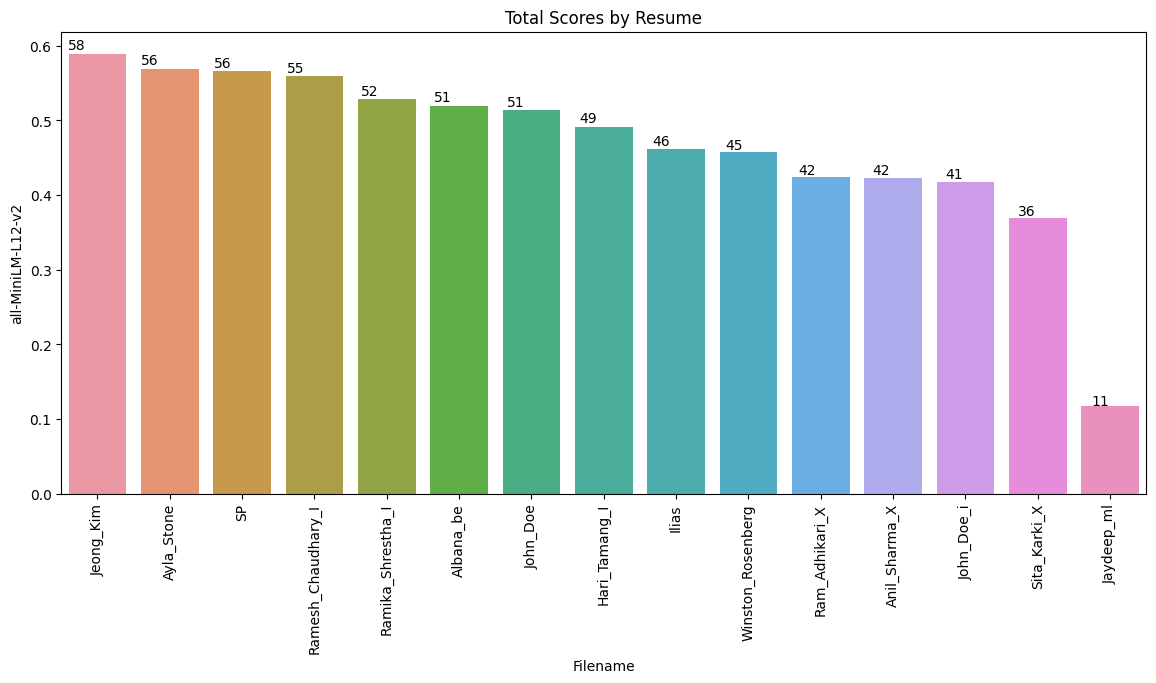

In [21]:
def visualize_scores(df):
    plt.figure(figsize=(14, 6))
    ax = sns.barplot(x="Filename", y="all-MiniLM-L12-v2", data=df.sort_values(by='all-MiniLM-L12-v2', ascending=False))
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height()*100)}', (p.get_x()*1.01, p.get_height()*1.01))
    plt.xticks(rotation=90)
    plt.title("Total Scores by Resume")
    plt.show()

visualize_scores(df_resume)